In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal
import math
import cv2
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('./Dataset/lion.JPG')
resize=cv2.resize(img,(120,120),2)
resize.shape

(120, 120, 3)

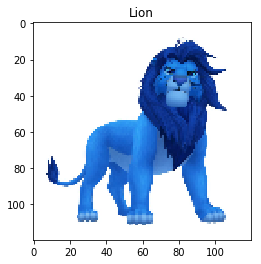

In [3]:
plt.title('Lion')
plt.imshow(resize)

## Gray Scale Image

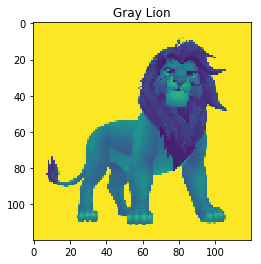

In [4]:
g_img=cv2.cvtColor(resize,cv2.COLOR_RGB2GRAY)
plt.title('Gray Lion')
plt.imshow(g_img)

## Convolution  Function

In [5]:
def ConvolutionApply(matrix,matr):
    width,height=matrix.shape
    f_width,f_height=matr.shape
    #print("Width and height",width,height)
    #print("Width and height of filter",f_width,f_height)
    r_size=width-f_width
    c_size=height-f_height
    lists=[]
    val=0
    for r in range(0,r_size):
        for c in range(0,c_size):
            i=-1
            j=-1
            val=0
            for m in range(r,f_width+r):
                i=i+1
                j=-1
                for n in range(c,f_height+c):
                    j=j+1
                    val=val+matr[i][j]*matrix[m][n]
            lists.append(val)
    #Replace filter values
    c=0
    for i in range(f_width//2,r_size+f_width//2):
        for j in range(f_height//2,c_size+f_height//2):
            matrix[i][j]=lists[c]
            c=c+1
    return matrix
        

## Generation Of Mask

In [6]:
def calculate_filter_size(sigma,T):
    sHalf = round(math.sqrt(-math.log(T) * 2 * sigma**2))
    N=2*sHalf+1
    [Y, X] = np.meshgrid( np.arange(-sHalf , sHalf+1),  np.arange(-sHalf, sHalf+1) )
    return X,Y



In [7]:
def calculate_gradient(x,y,sigma):
    const=1/2*np.pi*sigma**2
    gxy=const * np.exp(-((x**2+y**2)/2*sigma**2))
    fx=gxy*(-x/sigma**2)
    fy=gxy*(-y/sigma**2)
    gxy=(gxy//gxy.max())*255
    #fx=(fx//fx.max())*255
    #fy=(fy//fy.max())*255
    return gxy,fx,fy


In [8]:
def GenerationofMask(sigma,T):
    x,y=calculate_filter_size(sigma,T)
    gxy,fx,fy=calculate_gradient(x,y,sigma)
    return gxy,fx,fy
gxy,fx,fy=GenerationofMask(0.5,0.3)

## Applying Mask To Filter 

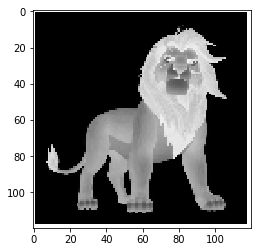

In [9]:
def ApplyGaussian(g_img,gxy):
    gxy_out = ConvolutionApply(g_img, gxy)
    plt.imshow(gxy_out, cmap = 'gray')
    plt.imsave('./Result/lio _Gxy_0.5.jpg'.format(0),gxy_out)
    return gxy_out
gxy_out=ApplyGaussian(g_img,gxy)

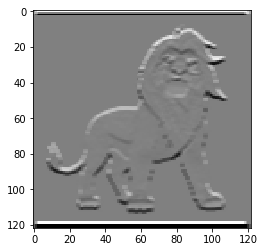

In [10]:
def ApplyGaussianDerivativeX(g_img,fx):
    fx_out = scipy.signal.convolve2d(g_img, fx)
    plt.imshow(fx_out, cmap = 'gray')
    plt.imsave('./Result/lion_fx_0.5.jpg'.format(0),fx_out)
    return fx_out
fx_out=ApplyGaussianDerivativeX(gxy_out,fx)  

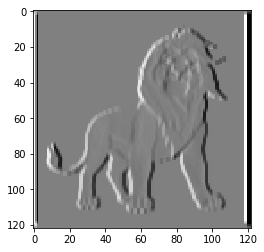

In [11]:
def ApplyGaussianDerivativeY(g_img,fy):
    fy_out = scipy.signal.convolve2d(g_img, fy)
    plt.imshow(fy_out, cmap = 'gray')
    plt.imsave('./Result/lion_fy_0.5.jpg'.format(0),fy_out)
    return fy_out
fy_out=ApplyGaussianDerivativeY(gxy_out,fy)  

## Compute Gradient Magnitude

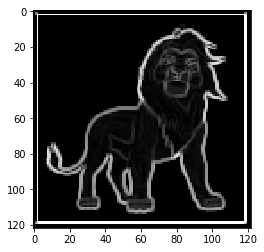

In [12]:
def Compute_Gradient_Magnitude(fx_out,fy_out):
    Magnitude=np.sqrt(fx_out**2+fy_out**2)
    M_out = ConvolutionApply(Magnitude, gxy)
    plt.imshow(M_out, cmap = 'gray')
    plt.imsave('./Result/lion_Magnitude_0.5.jpg'.format(0),M_out)
    return M_out
M_out=Compute_Gradient_Magnitude(fx_out,fy_out)

In [13]:
def Compute_Gradient_Direction(fy_out,fx_out):
    theta=np.arctan2(fy_out,fx_out)
    theta[theta < 0]+=360
    return theta
theta=Compute_Gradient_Direction(fy_out,fx_out)

## NON MAXIMA SUPRESSION

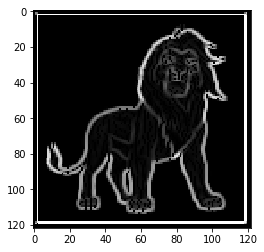

In [14]:
def NonMaximaSupression(M_out,theta):
    w,h=M_out.shape
    #print(w,h)
    for i in range(0+1,w-1):
        for j in range(0+1,h-1):
            if(theta[i][j]>=0 and theta[i][j]<=22.5 or theta[i][j]>=157.5 and theta[i][j] <= 202.5 or theta[i][j]>337.5 and theta[i][j]<360):
                point1=M_out[i][j+1]
                point2=M_out[i][j-1]
            elif(theta[i][j]>=22.5 and theta[i][j]<=67.5 or theta[i][j]>=202.5 and theta[i][j] <= 247.5):
                pint1=M_out[i-1][j+1]
                point2=M_out[i+1][j-1]
            elif(theta[i][j]>=67.5 and theta[i][j]<=112.5 or theta[i][j]>=247.5 and theta[i][j] <= 292.5):
                point1=M_out[i-1][j]
                point2=M_out[i+1][j]
            elif(theta[i][j]>=112.5 and theta[i][j]<=157.5 or theta[i][j]>=292.5 and theta[i][j]<=337.5):
                point1=M_out[i-1][j-1]
                point2=M_out[i+1][j+1]
            if(M_out[i][j]<point1 and M_out[i][j]<point2):
                M_out[i][j]=0
    plt.imshow(M_out, cmap = 'gray')
    plt.imsave('./Result/lion_quantized_0.5.jpg'.format(0),M_out)

    return M_out
                
            
NMS=NonMaximaSupression(M_out,theta)    

## Hysteresis Thresholding

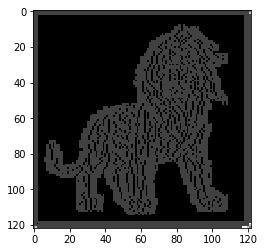

In [19]:
def HysteresisThresholding(NMS,TH,TL):
    width,height=NMS.shape
    visited=np.zeros((width,height))
    edge=255
    #print(width,height)
    #print(NMS.max())
    for i in range(1,width-1):
        for j in range(1,height-1):
            if(NMS[i][j]>TH and visited[i][j] != 1):
                visited[i][j]=1
                NMS[i][j]=edge
                if(NMS[i-1][j]>TL and visited[i-1][j]!=1):
                    NMS[i-1][j]=edge
                    visited[i-1][j]=1
                if(NMS[i+1][j]>TL and visited[i+1][j] !=1):
                    NMS[i+1][j]=edge
                    visited[i+1][j]=1
                if(NMS[i+1][j-1]>TL and visited[i+1][j-1] !=1):
                    NMS[i+1][j-1]=edge
                    visited[i+1][j-1]=1
                if(NMS[i+1][j+1]>TL and visited[i+1][j+1] !=1):
                    NMS[i+1][j+1]=edge
                    visited[i+1][j+1]=1
                if(NMS[i][j-1]>TL and visited[i][j-1] !=1):
                    NMS[i][j-1]=edge
                    visited[i][j-1]=1
                if(NMS[i][j+1]>TL and visited[i][j+1] !=1):
                    NMS[i][j+1]=edge
                    visited[i][j+1]=1
                if(NMS[i-1][j+1]>TL and visited[i-1][j+1] !=1):
                    NMS[i-1][j+1]=edge
                    visited[i-1][j+1]=1
                if(NMS[i-1][j-1]>TL and visited[i-1][j-1] !=1):
                    NMS[i-1][j-1]=edge
                    visited[i-1][j-1]=1
                    
    
    plt.imshow(NMS, cmap = 'gray')
    plt.imsave('./Result/lion_hysteresis_0.5_230_170.jpg'.format(0),M_out)
    plt.imsave('./Result/lion_finalResult_0.5_230_170.jpg'.format(0),M_out)



    
    
HysteresisThresholding(NMS,230,170)